In [2]:
import sys
from pathlib import Path
import importlib
import math

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap
from scipy.interpolate import interp1d
from scipy.optimize import root_scalar
from scipy.stats import norm
import seaborn as sns
from tqdm import tqdm


sys.path.insert(0, str(Path("../..").resolve()))
from curves import CubicSpline

# Local modules
#import gm_utils
#importlib.reload(gm_utils)  
#from gm_utils import visualize_density, sample, geodesic, energy
#from curves import CubicSpline

# Matplotlib settings
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsfonts}'

# Space noise

- Compute metric and curvature with respect to alpha(t) 
- Still need to do: Do geodesics with respect to alpha(t)

In [3]:
def compute_vector_field(x, t):
    """
    PF-ODE vector field for any alpha_sigma(t)
    Outputs dt and dx shaped to match the previous working version.
    x: (B, D)
    t: (B,)
    """
    x = x.clone().detach().requires_grad_(True)
    t = t.clone().detach().requires_grad_(True)

    alpha_t, sigma_t = alpha_sigma(t)

    log_alpha = torch.log(alpha_t)
    f_t = torch.autograd.grad(log_alpha.sum(), t, create_graph=True)[0]

    lambda_t = torch.log(alpha_t**2 / sigma_t**2)
    dlambda_dt = torch.autograd.grad(lambda_t.sum(), t, create_graph=True)[0]
    g2_t = - sigma_t**2 * dlambda_dt

    log_p_t = gaussian_mixture_density(x, t)
    grad_log_p_t = torch.autograd.grad(log_p_t.sum(), x, create_graph=True)[0]

    dx = f_t * x - 0.5 * g2_t * grad_log_p_t
    dt = -torch.ones_like(dx)

    dx = dx.view(-1)
    dt = dt.view(-1)
    return dt.detach().cpu().numpy(), dx.detach().cpu().numpy()


def sample(x, n_steps, t_start=1, t_end=0.9):
    """PF-ODE sampling"""
    t = t_start * torch.ones_like(x)
    dt_val = (t_start - t_end) / n_steps
    all_x = [x.detach().numpy()]
    all_t = [t.detach().numpy()]
    for i in range(n_steps):
        dt, dx = compute_vector_field(x, t)
        dt, dx = torch.from_numpy(dt), torch.from_numpy(dx)
        x = x + dt * dx * dt_val
        t = t + dt * dt_val
        all_x.append(x.detach().numpy())
        all_t.append(t.detach().numpy())
    return np.array(all_t), np.array(all_x)



def eds(t, x):
    """Implementation of the denoising mean, or Expected Denoised Sample (EDS) - based on Tweedie formula using the score function - Eq61 in the paper"""
    assert t.shape == x.shape
    assert t.ndim == 1
    alpha_t, sigma_t = alpha_sigma(t)    
    x.requires_grad_(True)
    log_p_t = gaussian_mixture_density(x, t)
    grad_log_p_t = torch.autograd.grad(log_p_t.sum(), x, create_graph=True)[0]
    res = (x + sigma_t ** 2 * grad_log_p_t)
    res = res / alpha_t
    return res

def mu(theta):
    """
    Implementation of the expectation parameter - Eq 22 in the paper. Since our data distribution is 1D, the spacetime is 2D
    Parameters
    ----------
    theta: torch.Tensor
        a batch of spacetime points of shape (N, 2), where the first column is the `time` component, and the second is the `space` component
    Returns
    ----------
    mu_t : torch.Tensor
        `time` component of the expectation parameter - tensor or shape (N,)
    mu_x : torch.Tensor
        `space` component of the expectation parameter - tensor of shape (N,)
    """
    t, x = theta[:, 0], theta[:, 1]
    alpha_t, sigma_t = alpha_sigma(t)
    x.requires_grad_(True)
    f = eds(t, x)
    div = torch.autograd.grad(f.sum(), x, create_graph=True)[0] # In 1D the divergence is just the derivative
    mu_t, mu_x = sigma_t ** 2 / alpha_t * div + f ** 2, f
    return mu_t, mu_x

def eta(theta):
    """
    Implementation of the natural parameter - Eq 18 in the paper.
    Parameters
    ----------
    theta: torch.Tensor
        a batch of spacetime points of shape (N, 2), where the first column is the `time` component, and the second is the `space` component
    Returns
    ----------
    eta_t : torch.Tensor
        `time` component of the natural parameter - tensor or shape (N,)
    eta_x : torch.Tensor
        `space` component of the natural parameter - tensor of shape (N,)
    """
    t, x = theta[:, 0], theta[:, 1]
    alpha_t, sigma_t = alpha_sigma(t)
    return -0.5 * alpha_t**2/sigma_t**2, alpha_t/sigma_t**2 * x



def energy(theta):
    """
    Implementation of the energy of a discretized curve - Eq 23 in the paper.
    Parameters
    ----------
    theta: torch.Tensor
        a batch of spacetime points of shape (N, 2), where the first column is the `time` component, and the second is the `space` component
    Returns
    ----------
    energy : torch.Tensor
        Energy represented as tensor of shape (,)
    """
    mu_t, mu_x = mu(theta)
    eta_t, eta_x = eta(theta)
    energies = (mu_t[1:] - mu_t[:-1]) * (eta_t[1:] - eta_t[:-1]) + (mu_x[1:] - mu_x[:-1]) * (eta_x[1:] - eta_x[:-1])
    return energies.sum()

def geodesic(theta1, theta2, n_opt_steps, num_intermediate_points, num_nodes=20):
    """
    Implementation of approximate geodesic, parametrizes the curve as a CubicSpline and minimizes its energy w.r.t. curve's parameters using Adam optimizer
    Parameters
    ----------
    theta1: torch.Tensor
        First endpoint of the curve, represented as a point in spacetime, i.e. (2,) tensor
    theta2: torch.Tensor
        Second endpoint of the curve, represented as a point in spacetime, i.e. (2,) tensor
    n_opt_steps : int
        Number of optimization steps
    num_intermediate_points : int
        Number of points to discretize the curve into (in the paper: `N`)
    num_nodes : int
        Parameter of the CubicSpline. The higher the number of nodes, the more flexible/expressive the curve
    """
    curve = CubicSpline(begin=theta1, end=theta2, num_nodes=num_nodes)
    optimizer = torch.optim.Adam(curve.parameters(), lr=1e-1)
    t_tensor = torch.linspace(0, 1, num_intermediate_points).unsqueeze(0)
    for step_id in tqdm(range(n_opt_steps)):
        optimizer.zero_grad()
        theta = curve(t_tensor)[0]
        loss = energy(theta)
        loss.backward()
        optimizer.step()
    return curve(t_tensor)[0].detach().numpy()

def geodesic(theta1, theta2, n_opt_steps, num_intermediate_points, num_nodes=20):
    """
    Implementation of approximate geodesic, parametrizes the curve as a CubicSpline and minimizes its energy w.r.t. curve's parameters using Adam optimizer
    Parameters
    ----------
    theta1: torch.Tensor
        First endpoint of the curve, represented as a point in spacetime, i.e. (2,) tensor
    theta2: torch.Tensor
        Second endpoint of the curve, represented as a point in spacetime, i.e. (2,) tensor
    n_opt_steps : int
        Number of optimization steps
    num_intermediate_points : int
        Number of points to discretize the curve into (in the paper: `N`)
    num_nodes : int
        Parameter of the CubicSpline. The higher the number of nodes, the more flexible/expressive the curve
    """
    curve = CubicSpline(begin=theta1, end=theta2, num_nodes=num_nodes)
    optimizer = torch.optim.Adam(curve.parameters(), lr=1e-1)
    t_tensor = torch.linspace(0, 1, num_intermediate_points).unsqueeze(0)
    alpha_t, sigma_t = alpha_sigma(t_tensor)

    for step_id in tqdm(range(n_opt_steps)):
        optimizer.zero_grad()
        theta = curve(alpha_t)[0]
        loss = energy(theta)
        loss.backward()
        optimizer.step()
    return curve(t_tensor)[0].detach().numpy()



def plot_ode_geodesics(points):
    t_min = 0.1
    for i, x in enumerate(points):
        pf_ode_sample = sample(x, 512, t_start=0.99, t_end=t_min)
        pf_ode_theta = torch.from_numpy(np.concatenate(pf_ode_sample, axis=1))
        print('Energy of pf ode trajectory:', energy(pf_ode_theta).item(), end=' ')
        theta1 = pf_ode_theta[0]
        theta2 = pf_ode_theta[-1]
        print('theta1', theta1)
        print('theta2', theta2)
        shortest_path12 = geodesic(theta1, theta2, n_opt_steps=10, num_intermediate_points=1000, num_nodes=800)
        print('Energy of a geodesic:', energy(torch.from_numpy(shortest_path12)).item())
        if i == 0:
            label_pf = 'PF-ODE trajectory'
            label_g = 'Spacetime Geodesic'
        else:
            label_pf = None
            label_g = None
        ax.plot(pf_ode_theta[:, 0], pf_ode_theta[:, 1], color='C3', label=label_pf)
        ax.plot(shortest_path12[:, 0], shortest_path12[:, 1], color='C3', linestyle='--', label=label_g)


def gaussian_mixture_density_alpha(x, t):
    """
    Marginal log-density parameterised by alpha instead of time t.
    
    x: Tensor of shape (N,)
    alpha: Tensor of shape (N,) or scalar
    """
    # Ensure correct shape
    alpha, sigma_t = alpha_sigma(t)
    alpha = alpha.view(-1)
    sigma = torch.sqrt(1.0 - alpha**2)

    means = alpha[:, None] * original_means[None, :]
    variances = sigma[:, None]**2 + alpha[:, None]**2 * original_variance

    log_probs = (
        torch.log(weights[None, :])
        - 0.5 * (
            torch.log(2 * torch.pi * variances)
            + (x[:, None] - means) ** 2 / variances
        )
    )

    log_p_alpha = torch.logsumexp(log_probs, dim=1)
    return log_p_alpha

def gaussian_mixture_density(x, alpha):
    """
    Correct marginal log-density p(x | alpha)
    corresponding to:
    N(alpha * mu, alpha^2 * Sigma + (1 - alpha^2) I)
    """
    alpha = alpha.view(-1)

    # noise variance is FIXED by the model
    sigma2 = 1.0 - alpha**2

    means = alpha[:, None] * original_means[None, :]
    variances = alpha[:, None]**2 * original_variance + sigma2[:, None]

    log_probs = (
        torch.log(weights[None, :])
        - 0.5 * (
            torch.log(2 * torch.pi * variances)
            + (x[:, None] - means) ** 2 / variances
        )
    )

    return torch.logsumexp(log_probs, dim=1)

def visualize_density_alpha2(ax):
    n_time = 50
    n_space = 200

    # 1. sample time
    t_vals = torch.linspace(0.0, 1.0, n_time)

    # 2. get alpha from the noise schedule
    alpha_vals, sigma_vals = alpha_sigma(t_vals)

    # 3. ensure alpha(0)=1 is on the LEFT
    alpha_vals = alpha_vals.flip(0)

    x_vals = torch.linspace(-1.5, 1.5, n_space)

    A, X = np.meshgrid(alpha_vals.numpy(), x_vals.numpy())

    densities = gaussian_mixture_density(
        torch.from_numpy(X.flatten()),
        torch.from_numpy(A.flatten())
    ).reshape(X.shape).detach()

    ax.contourf(1-A, X, densities, levels=25, cmap="viridis")
    ax.set_xlabel(r"$\alpha(t)$")
    ax.set_ylabel(r"$x$")

In [4]:
'''
------------------------------
Noise schedules to choose from
------------------------------
'''

def tau(t, kappa=0.2, d=1.0):
    """
    Time change τ(t):
        τ(t) = 2√(κd)t                  for t ∈ [0, 1/2]
              √(κd) + (1 - √(κd))(2t-1) for t ∈ [1/2, 1]
    """
    sqrt_kd = torch.tensor(kappa, dtype=t.dtype, device=t.device)
    tau_t = torch.where(
        t <= 0.5,
        2 * sqrt_kd * t,
        sqrt_kd + (1 - sqrt_kd) * (2 * t - 1)
    )
    return tau_t


def alpha_sigma(t, T=1.0, kappa=0.3, d=1.0):
    """
    Variance-preserving linear noise schedule composed with
    the nonlinear time change τ(t).
    """
    # Apply time change
    tau_t = tau(t, kappa=kappa, d=d)

    # Base linear-in-variance schedule using τ(t) instead of t
    sigma2_t = tau_t 
    sigma_t = sigma2_t
    alpha_t = 1.0 - sigma2_t

    return alpha_t, sigma_t

def log_SNR(t):
    """Implementation of the linear-logSNR noise schedule"""
    return LAMBDA_MAX + (LAMBDA_MIN - LAMBDA_MAX) * t


def alpha_sigma(t):
    lambda_t = log_SNR(t)
    alpha_t = torch.sigmoid(lambda_t).sqrt()
    sigma_t = torch.sigmoid(-lambda_t).sqrt()
    return alpha_t, sigma_t


def alpha_sigma(t, T=1.0):
    """
    Forward process parameters for a Variance-Preserving (VP) SDE
    with a *linear-in-noise-variance* schedule..
    """
    sigma2_t = t / T
    sigma_t = torch.sqrt(sigma2_t)
    alpha_t = torch.sqrt(1.0 - sigma2_t)

    return alpha_t, sigma_t

def alpha_sigma(t, T=1.0):
    """
    Forward process parameters for a Variance-Preserving (VP) SDE
    with a *linear-in-noise-variance* schedule..
    """
    sigma2_t = t / T
    sigma_t = torch.sqrt(sigma2_t)
    alpha_t = torch.sqrt(1.0 - sigma2_t)

    return alpha_t, sigma_t


def alpha_sigma(t, s=0.008):
    """
    Cosine noise schedule from 'Improved Denoising Diffusion Probabilistic Models' (Nichol & Dhariwal, 2021).

    Args:
        t: torch.Tensor with values in [0, 1]
        s: small offset to avoid singularities (default 0.008)

    Returns:
        alpha_t, sigma_t : tensors of same shape as t
    """
    t = torch.clamp(t, 0.0, 1.0)

    # f(t) = cos^2(((t + s)/(1 + s)) * pi/2)
    f_t = torch.cos(((t + s) / (1 + s)) * math.pi / 2) ** 2

    # use math.cos or a tensor constant to avoid the float→tensor error
    f_0 = math.cos((s / (1 + s)) * math.pi / 2) ** 2

    alpha_t_sq = f_t / f_0
    alpha_t = torch.sqrt(alpha_t_sq)
    sigma_t = torch.sqrt(1.0 - alpha_t_sq)

    return alpha_t, sigma_t


The probability density function is independent of alpha(t)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


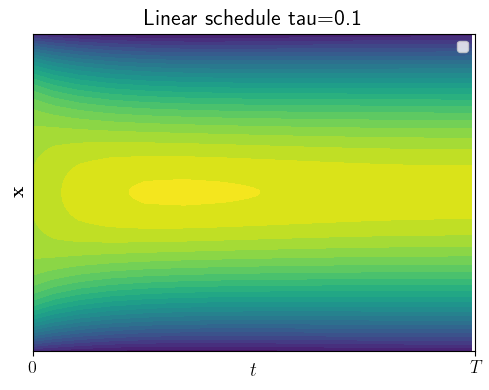

In [9]:
'''
---------------
Hyperparameters
---------------
'''
LAMBDA_MIN, LAMBDA_MAX = -10, 10  
num_discretization_points = 10
num_optimization_steps = 10
#original_means = torch.tensor([0], dtype=torch.float32) #0,0,0   #-1,1,0
#original_variance = torch.tensor(0.5, dtype=torch.float32) #0.4
#weights = torch.tensor([1], dtype=torch.float32)

original_means = torch.tensor([-1,0,1], dtype=torch.float32) #0,0,0   #-1,1,0
original_variance = torch.tensor(0.1, dtype=torch.float32) #0.4
weights = torch.tensor([1/3,1/3,1/3], dtype=torch.float32)

'''
---------------
Noise schedule
---------------
'''

def alpha_sigma(t, T=1.0, kappa=0.2, d=1.0):
    """
    Variance-preserving linear noise schedule composed with
    the nonlinear time change τ(t).
    """
    # Apply time change
    tau_t = tau(t, kappa=kappa, d=d)

    # Base linear-in-variance schedule using τ(t) instead of t
    sigma2_t = tau_t 
    sigma_t = sigma2_t
    alpha_t = 1.0 - sigma2_t

    return alpha_t, sigma_t


def alpha_sigma(t, s=0.008):
    """
    Cosine noise schedule from 'Improved Denoising Diffusion Probabilistic Models' (Nichol & Dhariwal, 2021).

    Args:
        t: torch.Tensor with values in [0, 1]
        s: small offset to avoid singularities (default 0.008)

    Returns:
        alpha_t, sigma_t : tensors of same shape as t
    """
    t = torch.clamp(t, 0.0, 1.0)

    # f(t) = cos^2(((t + s)/(1 + s)) * pi/2)
    f_t = torch.cos(((t + s) / (1 + s)) * math.pi / 2) ** 2

    # use math.cos or a tensor constant to avoid the float→tensor error
    f_0 = math.cos((s / (1 + s)) * math.pi / 2) ** 2

    alpha_t_sq = f_t / f_0
    alpha_t = torch.sqrt(alpha_t_sq)
    sigma_t = torch.sqrt(1.0 - alpha_t_sq)

    return alpha_t, sigma_t

def alpha_sigma(t):
    lambda_t = log_SNR(t)
    alpha_t = torch.sigmoid(lambda_t).sqrt()
    sigma_t = torch.sigmoid(-lambda_t).sqrt()
    return alpha_t, sigma_t

fig, ax = plt.subplots(figsize=(5, 4))
t_min = 0.1
visualize_density_alpha2(ax)
#plot_ode_geodesics(torch.tensor([[1.], [0.2], [-1]]))
ax.legend()
ax.set_xlim((t_min, 1))
ax.set_xticks([t_min, 1], [r'$0$', r'$T$'], fontsize=13)
ax.set_yticks([])
ax.set_xlabel(r'$t$', fontsize=14, labelpad=-10)
ax.set_ylabel(r'$\mathbf{x}$', fontsize=14)
ax.set_title('Linear schedule tau=0.1', fontsize=16)
plt.tight_layout()
plt.show()



We calculate the curvature and the metric with respect to t, and we do a change of coordinates

In [7]:
def metric_tensor_differentiable(theta_alpha):
    """
    theta_alpha: (N, 2) tensor with rows = [alpha, x]
    alpha_sigma_func: function t -> alpha(t) (returns torch tensor)
    
    Returns:
    I_alpha: (N,2,2) metric tensor in alpha coordinates
    theta_alpha: same as input, requires_grad=True
    """
    theta_alpha = theta_alpha.clone().detach().requires_grad_(True)
    N = theta_alpha.shape[0]

    alpha_vals = theta_alpha[:, 0]
    x_vals     = theta_alpha[:, 1]

    # -----------------------------
    # Numerically invert alpha -> t via autograd
    # -----------------------------
    # Here we solve alpha(t) = alpha_vals for t using a simple iteration
    # For simplicity, we assume small N and monotone alpha(t)

    t_vals = torch.zeros_like(alpha_vals)
    for i, alpha_target in enumerate(alpha_vals):
        t_guess = torch.tensor(0.5, requires_grad=True)
        optimizer = torch.optim.LBFGS([t_guess], max_iter=50, line_search_fn='strong_wolfe')
        def closure():
            optimizer.zero_grad()
            alpha_pred, _ = alpha_sigma(t_guess)
            loss = (alpha_pred - alpha_target)**2
            loss.backward()
            return loss
        optimizer.step(closure)
        t_vals[i] = t_guess.detach()

    t_vals.requires_grad_(True)
    theta_t = torch.stack([t_vals, x_vals], dim=1)

    # -----------------------------
    # Compute original metric in t-coordinates
    # -----------------------------
    
    eta_t, eta_x = eta(theta_t)
    mu_t, mu_x   = mu(theta_t)
    eta_vec = torch.stack([eta_t, eta_x], dim=1)
    mu_vec  = torch.stack([mu_t, mu_x], dim=1)

    I_t = torch.zeros((N, 2, 2), dtype=theta_alpha.dtype, device=theta_alpha.device)
    for n in range(N):
        J_eta = torch.zeros((2,2), dtype=theta_alpha.dtype, device=theta_alpha.device)
        J_mu  = torch.zeros((2,2), dtype=theta_alpha.dtype, device=theta_alpha.device)
        for k in range(2):
            grad_eta_k = torch.autograd.grad(eta_vec[n,k], theta_t, retain_graph=True, create_graph=True)[0][n]
            grad_mu_k  = torch.autograd.grad(mu_vec[n,k], theta_t, retain_graph=True, create_graph=True)[0][n]
            J_eta[k,:] = grad_eta_k
            J_mu[k,:]  = grad_mu_k
        I_t[n] = J_eta.T @ J_mu

    # -----------------------------
    # Transform metric to alpha coordinates
    # -----------------------------
    # Compute dt/dalpha
    alpha_pred, _ = alpha_sigma(t_vals)
    dalpha_dt = torch.autograd.grad(alpha_pred.sum(), t_vals, create_graph=True)[0]
    dt_dalpha = 1.0 / dalpha_dt

    I_alpha = torch.zeros_like(I_t)
    for n in range(N):
        J = torch.eye(2, dtype=theta_alpha.dtype, device=theta_alpha.device)
        J[0,0] = dt_dalpha[n]
        I_alpha[n] = J.T @ I_t[n] @ J

    return I_alpha, theta_alpha



def compute_sectional_curvature(theta):
    """
    theta : torch.Tensor
        Shape (N, 2), coordinates (t, x_t)
    """

    g, theta_diff = metric_tensor_differentiable(theta)
    N = g.shape[0]
    g_inv = torch.inverse(g)  

    christoffel = torch.zeros((N, 2, 2, 2), dtype=theta.dtype, device=theta.device)
    g_derivs = torch.zeros((N, 2, 2, 2), dtype=theta.dtype, device=theta.device)

    #Compute all the derivatives of the metric
    for n in range(N):
        for i in range(2):
            for j in range(2):
                
                grad_outputs = torch.zeros_like(g[n, i, j])
                grad_outputs = grad_outputs + 1.0

                grad_g_ij = torch.autograd.grad(
                    g[n, i, j], theta_diff,
                    grad_outputs=grad_outputs,
                    retain_graph=True,
                    create_graph=True,
                    only_inputs=True
                )[0][n]  

                g_derivs[n, i, j, :] = grad_g_ij

    # Compute Christoffel symbols: Γ^k_ij 
    for n in range(N):
        for k in range(2):
            for i in range(2):
                for j in range(2):
                    sum_term = 0.0
                    for l in range(2):
                        bracket_term = (g_derivs[n, i, l, j] +    
                                       g_derivs[n, j, l, i] -     
                                       g_derivs[n, i, j, l])      
                        sum_term += g_inv[n, k, l] * bracket_term

                    christoffel[n, k, i, j] = 0.5 * sum_term

    # Compute Riemann tensor component R^1_212

    R_1212 = torch.zeros(N, dtype=theta.dtype, device=theta.device)

    for n in range(N):
        # i, j, k, l = 0, 1, 0, 1  
        i, j, k, l = 0, 1, 0, 1

        if christoffel[n, i, j, l].requires_grad:
            dchrist_jl_k = torch.autograd.grad(
                christoffel[n, i, j, l], theta_diff,
                grad_outputs=torch.ones_like(christoffel[n, i, j, l]),
                retain_graph=True,
                create_graph=False,
                only_inputs=True
            )[0][n, k]
        else:
            dchrist_jl_k = torch.tensor(0.0, dtype=theta.dtype, device=theta.device)

        if christoffel[n, i, j, k].requires_grad:
            dchrist_jk_l = torch.autograd.grad(
                christoffel[n, i, j, k], theta_diff,
                grad_outputs=torch.ones_like(christoffel[n, i, j, k]),
                retain_graph=True,
                create_graph=False,
                only_inputs=True
            )[0][n, l]
        else:
            dchrist_jk_l = torch.tensor(0.0, dtype=theta.dtype, device=theta.device)

        
        quad1 = sum(christoffel[n, i, m, k] * christoffel[n, m, j, l] for m in range(2))
        quad2 = sum(christoffel[n, i, m, l] * christoffel[n, m, j, k] for m in range(2))

        R_1212[n] = dchrist_jl_k - dchrist_jk_l + quad1 - quad2

   
    # Compute the missing upper-index component R^1_101
    R_2212 = torch.zeros(N, dtype=theta.dtype, device=theta.device) 

    for n in range(N):
        i2, j2, k2, l2 = 1, 1, 0, 1 
        if christoffel[n, i2, j2, l2].requires_grad:
            dchrist_jl_k_2 = torch.autograd.grad(
                christoffel[n, i2, j2, l2], theta_diff,
                grad_outputs=torch.ones_like(christoffel[n, i2, j2, l2]),
                retain_graph=True,
                create_graph=False,
                only_inputs=True
            )[0][n, k2]
        else:
            dchrist_jl_k_2 = torch.tensor(0.0, dtype=theta.dtype, device=theta.device)

        if christoffel[n, i2, j2, k2].requires_grad:
            dchrist_jk_l_2 = torch.autograd.grad(
                christoffel[n, i2, j2, k2], theta_diff,
                grad_outputs=torch.ones_like(christoffel[n, i2, j2, k2]),
                retain_graph=True,
                create_graph=False,
                only_inputs=True
            )[0][n, l2]
        else:
            dchrist_jk_l_2 = torch.tensor(0.0, dtype=theta.dtype, device=theta.device)

        quad1_2 = sum(christoffel[n, i2, m, k2] * christoffel[n, m, j2, l2] for m in range(2))
        quad2_2 = sum(christoffel[n, i2, m, l2] * christoffel[n, m, j2, k2] for m in range(2))

        R_2212[n] = dchrist_jl_k_2 - dchrist_jk_l_2 + quad1_2 - quad2_2

    R_lowered_1212 = g[:, 0, 0] * R_1212 + g[:, 0, 1] * R_2212
    det_g = torch.det(g)  # (N,)
    K = R_lowered_1212 / det_g

    return K

sectional curvature at t=0.10, xt=-1.60: nan
sectional curvature at t=0.10, xt=-1.53: nan
sectional curvature at t=0.10, xt=-1.45: nan
sectional curvature at t=0.10, xt=-1.38: nan
sectional curvature at t=0.10, xt=-1.31: nan
sectional curvature at t=0.10, xt=-1.24: nan
sectional curvature at t=0.10, xt=-1.16: nan
sectional curvature at t=0.10, xt=-1.09: nan
sectional curvature at t=0.10, xt=-1.02: nan
sectional curvature at t=0.10, xt=-0.95: nan
sectional curvature at t=0.10, xt=-0.87: nan
sectional curvature at t=0.10, xt=-0.80: nan
sectional curvature at t=0.10, xt=-0.73: nan
sectional curvature at t=0.10, xt=-0.65: nan
sectional curvature at t=0.10, xt=-0.58: nan
sectional curvature at t=0.10, xt=-0.51: nan
sectional curvature at t=0.10, xt=-0.44: nan
sectional curvature at t=0.10, xt=-0.36: nan
sectional curvature at t=0.10, xt=-0.29: nan
sectional curvature at t=0.10, xt=-0.22: nan
sectional curvature at t=0.10, xt=-0.15: nan
sectional curvature at t=0.10, xt=-0.07: nan
sectional 

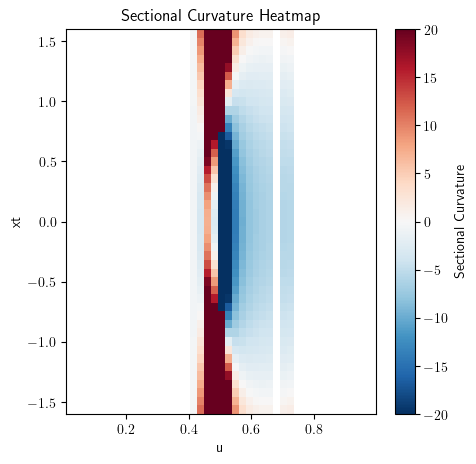

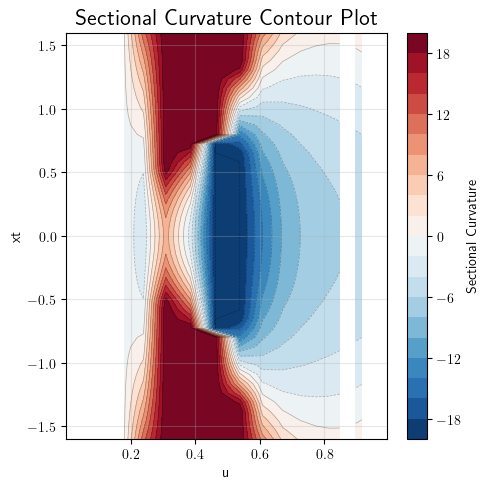


Heatmap computed with:
- t range: 0.1 to 1.0 (45 points)
- xt range: -1.6 to 1.6 (45 points)
- Curvature range: nan to nan


In [8]:
'''
----------------------
Choose hyperparameters
----------------------

'''

original_means = torch.tensor([0], dtype=torch.float32)
original_variance = torch.tensor(0.01, dtype=torch.float32) 
weights = torch.tensor([1], dtype=torch.float32)

'''
----------------------
Choose noise schedule
----------------------

'''

def log_SNR(t):
    """Implementation of the linear-logSNR noise schedule"""
    return LAMBDA_MAX + (LAMBDA_MIN - LAMBDA_MAX) * t


def alpha_sigma(t):
    lambda_t = log_SNR(t)
    alpha_t = torch.sigmoid(lambda_t).sqrt()
    sigma_t = torch.sigmoid(-lambda_t).sqrt()
    return alpha_t, sigma_t



t_range = np.linspace(0.1, 0.99,45)  
xt_range = np.linspace(-1.6, 1.6, 45)    
T, XT = np.meshgrid(t_range, xt_range)

curvature_values = np.zeros_like(T)

for i, t in enumerate(t_range):
    for j, xt in enumerate(xt_range):

        t_tensor = torch.tensor(t, dtype=torch.float32)  # convert to tensor
        u, v = alpha_sigma(t_tensor)
        u_scalar = (u).item()  # convert 1-element tensor to float
                      # u is now a tensor
        tensor_input = torch.tensor([[u_scalar, xt]], dtype=torch.float32)  # final input
        curvature = compute_sectional_curvature(tensor_input)

        if torch.is_tensor(curvature):
            curvature_values[j, i] = curvature.item()
        else:
            curvature_values[j, i] = curvature
        
        if curvature_values[j, i] > 20:
            curvature_values[j, i] = 20

        if curvature_values[j, i] < -20:
            curvature_values[j, i] = -20

        print(f'sectional curvature at t={t:.2f}, xt={xt:.2f}: {curvature_values[j, i]:.4f}')

u_values = np.array([alpha_sigma(torch.tensor(t, dtype=torch.float32))[0].item() for t in t_range])

plt.figure(figsize=(5, 5))
plt.imshow(curvature_values, 
           extent=[u_values.min(), u_values.max(), xt_range.min(), xt_range.max()],
           origin='lower', aspect='auto', cmap='RdBu_r')

plt.colorbar(label='Sectional Curvature')
plt.title('Sectional Curvature Heatmap')
plt.xlabel('u')   # <-- changed from 't' to 'u'
plt.ylabel('xt')
plt.show()


U, XT = np.meshgrid(1-u_values, xt_range)  # meshgrid now in u, xt

plt.figure(figsize=(5, 5))
contour = plt.contourf(U, XT, curvature_values, levels=25, cmap='RdBu_r')
plt.colorbar(contour, label='Sectional Curvature')
plt.contour(U, XT, curvature_values, levels=20, colors='black', alpha=0.3, linewidths=0.5)
plt.title('Sectional Curvature Contour Plot', fontsize=16, fontweight='bold')
plt.xlabel('u')
plt.ylabel('xt')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nHeatmap computed with:")
print(f"- t range: {t_range.min():.1f} to {t_range.max():.1f} ({len(t_range)} points)")
print(f"- xt range: {xt_range.min():.1f} to {xt_range.max():.1f} ({len(xt_range)} points)")
print(f"- Curvature range: {curvature_values.min():.4f} to {curvature_values.max():.4f}")

## Still need to implement geodesic

In [ ]:
'''
---------------
Hyperparameters
---------------
'''
import torch


LAMBDA_MIN, LAMBDA_MAX = -10, 10  
num_discretization_points = 1000
num_optimization_steps = 200

original_means = torch.tensor([-1,1], dtype=torch.float32) #0,0,0   #-1,1,0
original_variance = torch.tensor(0.01, dtype=torch.float32) #0.4
weights = torch.tensor([1/2,1/2], dtype=torch.float32)

theta1 = torch.tensor([0.001, 0.5]) #(theta=(t, x))
theta2 = torch.tensor([0.001, -0.5])


'''
---------------------
Choose noise schedule
---------------------
'''

def tau(t, kappa=0.2, d=1.0):
    """
    Time change τ(t):
        τ(t) = 2√(κd)t                  for t ∈ [0, 1/2]
              √(κd) + (1 - √(κd))(2t-1) for t ∈ [1/2, 1]
    """
    sqrt_kd = torch.tensor(kappa, dtype=t.dtype, device=t.device)
    tau_t = torch.where(
        t <= 0.5,
        2 * sqrt_kd * t,
        sqrt_kd + (1 - sqrt_kd) * (2 * t - 1)
    )
    return tau_t


def alpha_sigma(t, T=1.0, kappa=0.8, d=1.0):
    """
    Variance-preserving linear noise schedule composed with
    the nonlinear time change τ(t). kappa controls how quickly the information gets destroyed. 
    """
    # Apply time change
    tau_t = tau(t, kappa=kappa, d=d)

    # Base linear-in-variance schedule using τ(t) instead of t
    sigma2_t = tau_t 
    sigma_t = sigma2_t
    alpha_t = 1.0 - sigma2_t

    return alpha_t, sigma_t



shortest_path12 = geodesic(theta1, theta2, num_optimization_steps, num_discretization_points, num_nodes=800)
print('Energy of a geodesic:', energy(torch.from_numpy(shortest_path12)).item())

def get_means_and_variances(t, x):
    """
    When the data distribution p0 is a Gaussian mixture, then for every (t, xt), the `denoising distribution` (Eq 15 in the paper) is also a Gaussian Mixture. This function calculates the means and std of the denoising distribution in our Gaussian Mixture toy example. This function is used only to visualize the transition of densities in Figure 1.
    """
    alpha, sigma = alpha_sigma(t)
    snr = alpha**2 / sigma**2
    variance_inv = 1 / original_variance + snr
    variance = 1 / variance_inv
    means = original_means/original_variance + alpha/sigma ** 2 * x
    return (means * variance).numpy(), variance.numpy()


def visualize_density_w_geodesic(ax):
    visualize_density(ax)
    ax.set_xlabel(r"$t$", labelpad=-12, fontsize=14)
    ax.set_yticks([])
    ax.set_xticks([0, 1], [r'$0$', r'$T$'], fontsize=14)
    ax.scatter(*theta1.numpy(), color='blue', s=5)
    ax.scatter(*theta2.numpy(), color='red', s=5)

    points = shortest_path12

    segments = np.concatenate([points[:-1, None], points[1:, None]], axis=1)
    norm = plt.Normalize(0, len(points) - 1)
    cmap = LinearSegmentedColormap.from_list('blue_red_gradient', ['blue', 'red'], N=len(points))

    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(np.arange(len(points)))
    lc.set_linewidth(2)

    ax.add_collection(lc)
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.set_ylabel(r"$\mathbf{x}$", fontsize=14)
fig, (ax2, ax1) = plt.subplots(ncols=2, figsize=(5, 3), width_ratios=[1, 3])

visualize_density_w_geodesic(ax1)

num_plots = num_discretization_points

cmap = LinearSegmentedColormap.from_list('blue_red_gradient', ['blue', 'red'], N=num_plots)
colors = [cmap(i / (num_plots - 1)) for i in range(num_plots)]

indices = np.round(np.linspace(0, num_plots - 1, num_plots)).astype(np.int32)
x = np.linspace(-6, 8, 1000)
max_pdf = 0

for idx in range(num_plots):
    theta = torch.from_numpy(shortest_path12[idx])
    mean, var = get_means_and_variances(theta[0], theta[1])
    pdf = np.zeros_like(x)
    for mean_i, weight_i in zip(mean, weights):
        pdf += weight_i.item() * norm.pdf(x, loc=mean_i, scale=var ** 0.5)
    pdf = pdf
    max_pdf = max(max_pdf, np.max(pdf))
    if idx == 0 or idx == num_plots - 1:
        alpha = 1
    else:
        alpha = 0.3
    ax2.plot(-pdf, x, color=colors[idx], alpha=alpha)
    ax2.set_ylim((-4, 4))
    ax2.set_xlim((-1.1 * max_pdf, 0))

ax2.set_xlabel(r'$\mathbf{x}_0 \mid \mathbf{x}_t$', fontsize=14)
ax2.set_xticks([])
ax2.set_yticks([])
plt.subplots_adjust(wspace=0.02)

